In [19]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pybaseball import statcast, cache
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import joblib
import math
from pybaseball import statcast
import scipy.stats as stats
#from catboost import Pool
#import optuna
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, precision_score
import sqlite3
cache.enable()

In [20]:
data = pd.read_csv('savant_data.csv')

In [21]:
data['velocity'].mean()

np.float64(88.21048584411045)

In [22]:
# First, let's select the key features for the "Stuff+" model as discussed:
# - 'pitch_type'
# - 'pitch_percent'
# - 'swing_miss_percent'
# - 'arm_angle'
# - 'xbadiff'
# - 'xobp'
# - 'xslg'
# - 'pitcher_run_value_per_100'
# - 'batter_run_value_per_100'

# We will also select 'swing_miss_percent' as our initial target variable

# Selecting the relevant features
selected_columns = [
    'pitch_type', 'pitch_percent', 'swing_miss_percent', 'arm_angle', 
    'xbadiff', 'xobp', 'xslg', 'pitcher_run_value_per_100', 'batter_run_value_per_100'
]

data = data.dropna(subset=selected_columns)

# Extracting the features and target variable
features = data[selected_columns]
target = data['swing_miss_percent']

# One-hot encoding the categorical 'pitch_type' column to handle it in the model
features_encoded = pd.get_dummies(features, columns=['pitch_type'], drop_first=True)

# Splitting the data into training and testing sets for modeling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# We will now train an initial regression model. I'll start with a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the mean squared error for performance evaluation
mse = mean_squared_error(y_test, y_pred)
mse


np.float64(0.0022136422338569946)

In [23]:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison)

      Actual  Predicted
1587    15.3     15.308
2203    26.9     26.901
772     24.1     24.100
1732    31.1     31.104
387     24.8     24.799
...      ...        ...
1905     9.6      9.615
252     34.6     34.597
1793    21.9     21.900
2332    10.3     10.334
2103    12.1     12.095

[573 rows x 2 columns]


In [24]:
'''
data['SwingMiss_norm'] = (data['swing_miss_percent'] / data['swing_miss_percent'].mean()) * 100
data['xwOBA_norm'] = ((data['xwoba'] / data['xwoba'].mean())) * 100 # Inverse
data['RunExp_norm'] = ((data['run_exp'] / data['run_exp'].mean())) * 100  # Inverse

# Assigning weights
w1, w2, w3 = .3, .2, .5

# Calculating Stuff+
data['Stuff+'] = (
    w1 * data['SwingMiss_norm'] +
    w2 * data['xwOBA_norm'] +
    w3 * data['RunExp_norm']
)

# Display the first few rows of the Stuff+ calculation
data[['swing_miss_percent', 'xobp', 'pitcher_run_value_per_100', 'Stuff+']].head()
'''

"\ndata['SwingMiss_norm'] = (data['swing_miss_percent'] / data['swing_miss_percent'].mean()) * 100\ndata['xwOBA_norm'] = ((data['xwoba'] / data['xwoba'].mean())) * 100 # Inverse\ndata['RunExp_norm'] = ((data['run_exp'] / data['run_exp'].mean())) * 100  # Inverse\n\n# Assigning weights\nw1, w2, w3 = .3, .2, .5\n\n# Calculating Stuff+\ndata['Stuff+'] = (\n    w1 * data['SwingMiss_norm'] +\n    w2 * data['xwOBA_norm'] +\n    w3 * data['RunExp_norm']\n)\n\n# Display the first few rows of the Stuff+ calculation\ndata[['swing_miss_percent', 'xobp', 'pitcher_run_value_per_100', 'Stuff+']].head()\n"

In [25]:
print(data['xwoba'].min())
print(data['xwoba'].max())
print(data['xwoba'].mean())
print(data['pitcher_run_exp'].min())
print(data['pitcher_run_exp'].max())
print(data['pitcher_run_exp'].mean())


0.075
0.636
0.31300489339391824
-53.1
79.3
0.8665851101013635


In [26]:
# different normailzation so all are around 60-150, average at 100
data['pre_new_all_+'] = data['pitcher_run_exp'] - data['pitcher_run_exp'].min()
print(data['pre_new_all_+'].mean())

53.96658511010136


In [27]:
data = pd.read_csv('savant_data.csv')

std_dev_pre = data['pitcher_run_exp'].std()
std_dev_xwoba = data['xwoba'].std()
std_dev_swm = data['swing_miss_percent'].std()
#std_dev_hhr = data['hardhit_percent'].std()
#std_dev_prve100 = data['pitcher_run_value_per_100'].std()

# try with standard dev
data['SwingMiss_norm'] = ((data['swing_miss_percent'] - data['swing_miss_percent'].mean()) / std_dev_swm) * 10
data['xwOBA_norm'] = (((data['xwoba'].mean() - data['xwoba'])) / std_dev_xwoba) * 10
data['RunExp_norm'] = ((data['pitcher_run_exp'] - data['pitcher_run_exp'].mean()) / std_dev_pre) * 10
#data['HardHit_norm'] = ((data['hardhit_percent'].mean() - data['hardhit_percent']) / std_dev_hhr) * 10
#data['prve100_norm'] = ((data['pitcher_run_value_per_100'] - data['pitcher_run_value_per_100'].mean()) / std_dev_prve100) * 50

# Assigning weights
w1, w2, w3 = .2, .3, .5

# Calculating Stuff+
data['Stuff+'] = (
    w1 * data['SwingMiss_norm'] +
    w2 * data['xwOBA_norm'] +
    w3 * data['RunExp_norm']
)
#w4 * data['HardHit_norm']

data['Stuff+'] = (data['Stuff+']) + 100

# Display the first few rows of the Stuff+ calculation
data[['swing_miss_percent', 'xwoba', 'pitcher_run_exp', 'hardhit_percent', 'Stuff+']].head()

,swing_miss_percent,xwoba,pitcher_run_exp,hardhit_percent,Stuff+
0,44.9,0.225,72.7,32.053176,143.446997
1,25.7,0.300,79.3,34.270650,138.943549
2,39.5,0.243,60.0,29.984544,135.206928
3,26.0,0.299,61.8,46.261090,130.490609
4,42.3,0.221,46.6,28.617886,130.316410


In [28]:
features_sorted = data.sort_values(by='Stuff+', ascending=False)
print(data['Stuff+'].mean())
features_sorted.to_csv('savant_data.csv', index=False)

100.0


In [29]:
filtered_data = data[data['pitches'] >= 200]
filtered_data = filtered_data.sort_values(by='Stuff+', ascending=False)
filtered_data.to_csv('STUFF+Initial.csv', index=False)

In [30]:
print(filtered_data[filtered_data['pitch_type'] == 'FC'].head())

    pitches  player_id         player_name  total_pitches pitch_type  \
1      6224     669203      Burnes, Corbin          11943         FC   
14     2802     661403     Clase, Emmanuel           4080         FC   
17     1278     621237      Alvarado, José           3720         FC   
43      318     596112  Stephenson, Robert           2444         FC   
78     1489     677651        Garcia, Luis           5435         FC   

    pitch_percent     ba    iso  babip    slg  ...  z_diff  fastball_x_y  \
1            52.1  0.227  0.115  0.278  0.341  ...   -0.07          0.69   
14           68.7  0.212  0.071  0.259  0.283  ...   -0.02          0.69   
17           34.4  0.136  0.063  0.327  0.199  ...   -0.01          0.80   
43           13.0  0.101  0.152  0.143  0.253  ...    0.21          1.15   
78           27.4  0.167  0.119  0.237  0.286  ...    0.04          1.50   

    fastball_z_y  fastball_x  fastball_z  HardHit_norm  veloXmovement  \
1           6.01        0.69        6

In [31]:
# Stuff Model!
# First, let's select the key features for the "Stuff+" model as discussed:
# - 'pitch_type'
# - 'velocity'
# - 'api_break_z_induced'
# - 'api_break_x_arm'
# - 'release_extension'
# - 'spin_rate'
# - 'release_pos_x'
# - 'release_pos_z'
# - 'x_diff'  
# - 'z_diff'
# - 'Stuff+'

data = pd.read_csv('STUFF+Initial.csv')

# Adding New Variables, interactions
data['veloXspin'] = data['velocity'] * data['spin_rate']
data['veloXmovement'] = data['velocity'] * data['api_break_z_induced'] * data['api_break_x_arm']
data['vertXhoriz'] = data['api_break_z_induced'] * data['api_break_x_arm']
data['veloXrelease'] = data['release_extension'] * data['velocity']

# Selecting the relevant features
selected_columns = [
    'pitch_type', 'velocity', 'api_break_z_induced', 'api_break_x_arm', 'release_extension', 'spin_rate', 'release_pos_x_norm', 'release_pos_z', 'x_diff', 'z_diff', 'arm_angle'#, 'veloXrelease', 'veloXmovement' 
]

data = data.dropna(subset=selected_columns)

# Extracting the features and target variable
features = data[selected_columns]
target = data['Stuff+']

# One-hot encoding the categorical 'pitch_type' column to handle it in the model
features_encoded = pd.get_dummies(features, columns=['pitch_type'], drop_first=True)

# Splitting the data into training and testing sets for modeling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# We will now train an initial regression model. I'll start with a Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the model
rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=300, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate the mean squared error for performance evaluation
mse = mean_squared_error(y_test, y_pred)
mse


np.float64(41.35184826661097)

In [32]:
print(features_encoded.columns)
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison)
print(y_test.max())
print(y_pred.max())
print(y_test.mean())
print(y_pred.mean())
print(y_test.min())
print(y_pred.min())


Index(['velocity', 'api_break_z_induced', 'api_break_x_arm',
       'release_extension', 'spin_rate', 'release_pos_x_norm', 'release_pos_z',
       'x_diff', 'z_diff', 'arm_angle', 'pitch_type_CU', 'pitch_type_FC',
       'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL',
       'pitch_type_ST', 'pitch_type_SV'],
      dtype='object')
          Actual   Predicted
1587   98.513523   94.833432
2203   94.373385   99.550961
772   104.294450   97.401932
1732   97.657512  100.921396
387   108.308141   96.404547
...          ...         ...
1905   96.377887   95.984909
252   110.672963  100.443181
1793   97.274904  105.891042
2332   93.246773   97.709731
2103   95.097312   96.841240

[573 rows x 2 columns]
122.38070350605228
110.3440840127559
99.88571375702334
100.15958259784313
78.94121228988003
90.99538052908395


In [33]:

#pitch_data = [data['velocity'], data['api_break_z_induced'], data['api_break_x_arm'], data['release_extension'], data['spin_rate'], data['release_pos_x_norm'], data['release_pos_z'], data['x_diff'], data['z_diff'],  data['pitch_type_CU'], data['pitch_type_FC'], data['pitch_type_FF'], data['pitch_type_FO'], data['pitch_type_FS'], data['pitch_type_KC'], data['pitch_type_KN'], data['pitch_type_SC'], data['pitch_type_SI'], data['pitch_type_SL'], data['pitch_type_ST'], data['pitch_type_SV']]
predictions = rf_model.predict(features_encoded)
data['Stuff+_perdicted'] = predictions
data['Stuff_diff'] = data['Stuff+'] - data['Stuff+_perdicted']
#data['NewStuff+_perdicted'] = ((data['Stuff+_perdicted'] - 100) * 2) + 100
#data['NewStuff+_perdicted'] = ((data['Stuff+_perdicted'] - 100) * 2) + 100

data['NewStuff+_perdicted'] = np.where(
    data['pitch_type'] == 'FF',  # Condition
    ((data['Stuff+_perdicted'] - 100) * 1.8) + 100,  # If pitch_type is 'FF'
    ((data['Stuff+_perdicted'] - 100) * 1.5) + 100   # Otherwise
)

data['NewStuff_diff'] = data['Stuff+'] - data['NewStuff+_perdicted']
filtered_data = data[data['pitches'] >= 200]
filtered_data = filtered_data.sort_values(by='Stuff+', ascending=False)
filtered_data.to_csv('STUFF+Initial.csv', index=False)
mse = mean_squared_error(filtered_data['Stuff+'], filtered_data['NewStuff+_perdicted'])
mse

np.float64(22.555023035313194)

In [34]:
mse = mean_squared_error(filtered_data['Stuff+'], filtered_data['Stuff+_perdicted'])
mse

np.float64(27.096910811996473)

In [35]:

my_fastball = [92, 1.4, 1.2, 6.5, 2300, 2.55, 6.02, 0, 0, False, False, True, False, False, False, False, False, False, False, False, False]
#a_slider = rf_model.predict([my_slider], columns=features_encoded)

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
a_fastball = rf_model.predict([my_fastball])
print(a_fastball)

ValueError: X has 21 features, but RandomForestRegressor is expecting 22 features as input.

In [36]:

moy_sinker = [89, .92, 1.5, 5.67, 1880, 1.33, 4.92, 0, 0, False, False, False, False, False, False, False, False, True, False, False, False]
#a_slider = rf_model.predict([my_slider], columns=features_encoded)

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
a_fastball = rf_model.predict([moy_sinker])
print(a_fastball)

ValueError: X has 21 features, but RandomForestRegressor is expecting 22 features as input.

In [37]:
alp_fastball = [90, 1.5, 1.5, 6.5, 2400, 2.8, 5.5, 0, 0, False, False, True, False, False, False, False, False, False, False, False, False]
#a_slider = rf_model.predict([my_slider], columns=features_encoded)

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
a_fastball = rf_model.predict([alp_fastball])
print(a_fastball)

ValueError: X has 21 features, but RandomForestRegressor is expecting 22 features as input.

In [38]:
data = pd.read_csv('savant_data.csv')

std_dev_ba = data['ba'].std()
std_dev_ls = data['launch_speed'].std()
std_dev_swm = data['swing_miss_percent'].std()

# try with standard dev
data['SwingMiss_norm'] = ((data['swing_miss_percent'] - data['swing_miss_percent'].mean()) / std_dev_swm) * 10
data['ls_norm'] = ((data['launch_speed'].mean() - data['launch_speed']) / std_dev_ls) * 10
data['ba_norm'] = ((data['ba'].mean() - data['ba']) / std_dev_ba) * 10

# Assigning weights
w1, w2, w3 = 1/3, 1/3, 1/3

# Calculating Unhittable+
data['Unhittable+'] = (
    w1 * data['SwingMiss_norm'] +
    w2 * data['ls_norm'] +
    w3 * data['ba_norm']
)

data['Unhittable+'] = (data['Unhittable+'] + 100)

# Display the first few rows of the Stuff+ calculation
data[['swing_miss_percent', 'ba', 'launch_speed', 'Unhittable+']].head()

,swing_miss_percent,ba,launch_speed,Unhittable+
0,44.9,0.169,86.3,112.741857
1,25.7,0.227,87.8,100.936010
2,39.5,0.169,85.6,111.602048
3,26.0,0.211,91.3,98.130586
4,42.3,0.174,84.6,113.398423


In [39]:
filtered_data_unhit = data[data['pitches'] >= 200]
filtered_data_unhit = filtered_data_unhit.sort_values(by='Unhittable+', ascending=False)
filtered_data_unhit.to_csv('Unhittable+Initial.csv', index=False)
data['Unhittable+'].mean()

np.float64(100.00000000000001)

In [40]:
'''
data['release_pos_x_norm'] = data['release_pos_x']
data['release_pos_x_norm'] = data['release_pos_x_norm'].apply(lambda x: -x if x < 0 else x)

# Filter for fastballs
fastball_df = data[data['pitch_type'] == 'FF']

# Group by pitcher and calculate average x_pos and z_pos for fastballs
fastball_positions = fastball_df.groupby('player_name')[['release_pos_x_norm', 'release_pos_z']].mean().reset_index()
fastball_positions.rename(columns={'release_pos_x_norm': 'fastball_x', 'release_pos_z': 'fastball_z'}, inplace=True)

# Step 2: Merge fastball positions into the original dataset
data = data.merge(fastball_positions, on='player_name', how='left')

# Step 3: Calculate differences for x_pos and z_pos
data['x_diff'] = data['release_pos_x_norm'] - data['fastball_x']
data['z_diff'] = data['release_pos_z'] - data['fastball_z']

# Step 4: Filter for non-fastball pitches
secondary_pitches = data[data['pitch_type'] != 'FF']

# Step 5: Keep only relevant columns for the result
result = secondary_pitches[['player_name', 'pitch_type', 'x_diff', 'z_diff']]

# Output the result
print(result.head())
'''

"\ndata['release_pos_x_norm'] = data['release_pos_x']\ndata['release_pos_x_norm'] = data['release_pos_x_norm'].apply(lambda x: -x if x < 0 else x)\n\n# Filter for fastballs\nfastball_df = data[data['pitch_type'] == 'FF']\n\n# Group by pitcher and calculate average x_pos and z_pos for fastballs\nfastball_positions = fastball_df.groupby('player_name')[['release_pos_x_norm', 'release_pos_z']].mean().reset_index()\nfastball_positions.rename(columns={'release_pos_x_norm': 'fastball_x', 'release_pos_z': 'fastball_z'}, inplace=True)\n\n# Step 2: Merge fastball positions into the original dataset\ndata = data.merge(fastball_positions, on='player_name', how='left')\n\n# Step 3: Calculate differences for x_pos and z_pos\ndata['x_diff'] = data['release_pos_x_norm'] - data['fastball_x']\ndata['z_diff'] = data['release_pos_z'] - data['fastball_z']\n\n# Step 4: Filter for non-fastball pitches\nsecondary_pitches = data[data['pitch_type'] != 'FF']\n\n# Step 5: Keep only relevant columns for the result

In [41]:
print(data['release_pos_x_norm'].mean())
print(data[data['player_name'] == 'Valdez, Framber']['release_pos_x_norm'].mean())

1.8892904578818597
0.85


In [42]:
"""
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
"""

"\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [10, 20, None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 5],\n    'max_features': ['sqrt', 'log2', None]\n}\n\nrf_model = RandomForestRegressor(random_state=42)\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)\ngrid_search.fit(X_train, y_train)\n\n# Best parameters and model\nbest_params = grid_search.best_params_\nbest_rf_model = grid_search.best_estimator_\n"

In [43]:

print(best_params)
print(best_rf_model)


NameError: name 'best_params' is not defined

In [44]:
# Importing XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('STUFF+Initial.csv')

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    random_state=42,  # Ensure reproducibility
    n_estimators=300,  # Number of trees (default: 100)
    learning_rate=0.01,  # Step size shrinkage (default: 0.3)
    max_depth=4,       # Maximum tree depth (default: 6)
    objective='reg:squarederror'  # Regression objective
)
# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error for performance evaluation
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 43.61023477301773


In [45]:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(y_test.max())
print(y_pred.max())
print(y_test.mean())
print(y_pred.mean())
print(y_test.min())
print(y_pred.min())

122.38070350605228
114.24586
99.88571375702334
100.19613
78.94121228988003
93.29281


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Initialize the model
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_xgb_model = grid_search.best_estimator_


In [46]:
print(data.head())

   pitches  player_id      player_name  total_pitches pitch_type  \
0     4861     656302     Cease, Dylan          12527         SL   
1     6224     669203   Burnes, Corbin          11943         FC   
2     4610     450203  Morton, Charlie          11523         CU   
3     5534     543037     Cole, Gerrit          11058         FF   
4     4189     592332   Gausman, Kevin          11722         FS   

   pitch_percent     ba    iso  babip    slg  ...  HardHit_norm  \
0           38.8  0.169  0.098  0.262  0.267  ...      3.743808   
1           52.1  0.227  0.115  0.278  0.341  ...      2.277585   
2           40.0  0.169  0.098  0.267  0.267  ...      5.111614   
3           50.0  0.211  0.168  0.277  0.379  ...     -5.650648   
4           35.7  0.174  0.096  0.287  0.270  ...      6.015266   

   veloXmovement  vertXhoriz  veloXrelease  prve100_norm  veloXspin  \
0      -2.239677   -0.025773       536.173     20.258800   244797.3   
1     -27.360162   -0.288002       613.700    

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Load the dataset
data = pd.read_csv('STUFF+Initial.csv')

# Adding new variables/interactions
data['veloXspin'] = data['velocity'] * data['spin_rate']
data['veloXmovement'] = data['velocity'] * data['api_break_z_induced'] * data['api_break_x_arm']
data['vertXhoriz'] = data['api_break_z_induced'] * data['api_break_x_arm']
data['veloXrelease'] = data['release_extension'] * data['velocity']

# Selecting the relevant features
selected_columns = [
    'pitch_type', 'velocity', 'api_break_z_induced', 'api_break_x_arm',
    'release_extension', 'spin_rate', 'release_pos_x_norm', 'release_pos_z',
    'x_diff', 'z_diff', 'veloXspin', 'veloXmovement', 'veloXrelease'
]

data = data.dropna(subset=selected_columns)

# Extracting the features and target variable
features = data[selected_columns]
target = data['Stuff+']

# One-hot encoding the categorical 'pitch_type' column to handle it in the model
features_encoded = pd.get_dummies(features, columns=['pitch_type'], drop_first=True)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,  # Number of trees
    max_depth=10,  # Maximum tree depth
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Random sample of rows per tree
    colsample_bytree=0.8,  # Random sample of columns per tree
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 48.79309253520976


In [132]:
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(y_test.max())
print(y_pred.max())
print(y_test.mean())
print(y_pred.mean())
print(y_test.min())
print(y_pred.min())

122.38070350605228
115.31644
99.88571375702334
100.163025
78.94121228988003
87.24741


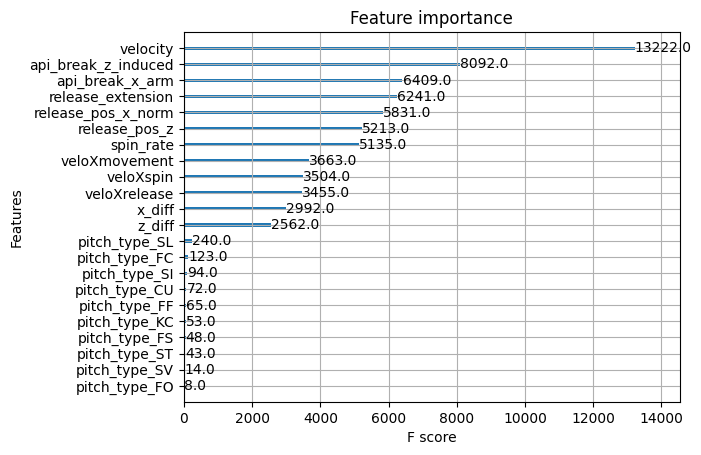

In [133]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_model)
plt.show()


In [134]:

#pitch_data = [data['velocity'], data['api_break_z_induced'], data['api_break_x_arm'], data['release_extension'], data['spin_rate'], data['release_pos_x_norm'], data['release_pos_z'], data['x_diff'], data['z_diff'],  data['pitch_type_CU'], data['pitch_type_FC'], data['pitch_type_FF'], data['pitch_type_FO'], data['pitch_type_FS'], data['pitch_type_KC'], data['pitch_type_KN'], data['pitch_type_SC'], data['pitch_type_SI'], data['pitch_type_SL'], data['pitch_type_ST'], data['pitch_type_SV']]
predictions = xgb_model.predict(features_encoded)
data['Stuff+_perdictedXG'] = predictions
data['Stuff_diffXG'] = data['Stuff+'] - data['Stuff+_perdictedXG']
filtered_data = data[data['pitches'] >= 200]
filtered_data = filtered_data.sort_values(by='Stuff+', ascending=False)
filtered_data.to_csv('STUFF+Initial.csv', index=False)
mse = mean_squared_error(filtered_data['Stuff+'], filtered_data['Stuff+_perdictedXG'])
mse


np.float64(9.772609533215608)

In [135]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_}")


KeyboardInterrupt: 

In [136]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Initialize the XGBoost model with the best hyperparameters
xgb_model = XGBRegressor(
    colsample_bytree=0.6,        # Fraction of features used per tree
    learning_rate=0.01,          # Step size shrinkage
    max_depth=6,                 # Maximum depth of the trees
    n_estimators=300,            # Number of boosting rounds (trees)
    subsample=0.8,               # Fraction of samples used per tree
    random_state=42              # For reproducibility
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 43.60329342348328


In [137]:
#pitch_data = [data['velocity'], data['api_break_z_induced'], data['api_break_x_arm'], data['release_extension'], data['spin_rate'], data['release_pos_x_norm'], data['release_pos_z'], data['x_diff'], data['z_diff'],  data['pitch_type_CU'], data['pitch_type_FC'], data['pitch_type_FF'], data['pitch_type_FO'], data['pitch_type_FS'], data['pitch_type_KC'], data['pitch_type_KN'], data['pitch_type_SC'], data['pitch_type_SI'], data['pitch_type_SL'], data['pitch_type_ST'], data['pitch_type_SV']]
predictions = xgb_model.predict(features_encoded)
data['Stuff+_perdictedXG'] = predictions
data['Stuff_diffXG'] = data['Stuff+'] - data['Stuff+_perdictedXG']
data['NewStuff+_perdictedXG'] = np.where(
    data['pitch_type'] == 'FF',  # Condition
    ((data['Stuff+_perdictedXG'] - 100) * 2) + 100,  # If pitch_type is 'FF'
    ((data['Stuff+_perdictedXG'] - 100) * 1.5) + 100   # Otherwise
)
data['NewStuff_diffXG'] = data['Stuff+'] - data['NewStuff+_perdictedXG']
filtered_data = data[data['pitches'] >= 200]
filtered_data = filtered_data.sort_values(by='Stuff+', ascending=False)
filtered_data.to_csv('STUFF+Initial.csv', index=False)
mse = mean_squared_error(filtered_data['Stuff+'], filtered_data['Stuff+_perdictedXG'])
mse


np.float64(33.23330494783515)

In [138]:
mse = mean_squared_error(filtered_data['Stuff+'], filtered_data['NewStuff+_perdictedXG'])
mse

np.float64(30.571418222561405)

In [142]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

# Initialize the XGBoost model with the best hyperparameters
xgb_model = XGBRegressor(
    colsample_bytree=0.6,        # Fraction of features used per tree
    learning_rate=0.01,          # Step size shrinkage
    max_depth=6,                 # Maximum depth of the trees
    n_estimators=300,            # Number of boosting rounds (trees)
    subsample=0.8,               # Fraction of samples used per tree
    random_state=42              # For reproducibility
)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_model, features_encoded, target, cv=5, scoring='neg_mean_squared_error')

# The returned cv_scores are negative because we used 'neg_mean_squared_error'
# So we negate them to get positive MSE values
cv_scores = -cv_scores

# Print the cross-validation results
print(f"Cross-validated MSE for each fold: {cv_scores}")
print(f"Mean Cross-validated MSE: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-validated MSE: {np.std(cv_scores)}")


Cross-validated MSE for each fold: [189.90322745  22.42955123  14.2789917   28.99555088 139.3390675 ]
Mean Cross-validated MSE: 78.98927775240742
Standard Deviation of Cross-validated MSE: 71.8746100816687


In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load the data
df = pd.read_csv('STUFF+Initial.csv')

# Features and target
features = ['pitch_type', 'velocity', 'api_break_z_induced', 'api_break_x_arm',
            'release_extension', 'spin_rate', 'release_pos_x_norm', 'release_pos_z',
            'x_diff', 'z_diff', 'veloXspin', 'veloXmovement', 'veloXrelease']
target = 'Stuff+'

# Drop rows with missing target values
df = df.dropna(subset=[target])

X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a pipeline using Gradient Boosting Regressor
pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)
# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 46.40703969859936


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Create the pipeline
pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model using grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best MSE score: {-grid_search.best_score_}")


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.